<a href="https://colab.research.google.com/github/daaaanish17/Image-Classification/blob/main/Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Animal Classification using Transfer Learning Model (MobileNetV2)*

Image Dataset Link: https://www.kaggle.com/datasets/alessiocorrado99/animals10

Importing Libraries

In [48]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input , decode_predictions
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Input
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras.models import load_model 
import pickle
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image

In [2]:
def img_data(dir_path, target_size, batch, class_lst, pre_processs):
  if pre_processs:
    generate_object = ImageDataGenerator(preprocessing_function=pre_processs)
  else:
    generate_object = ImageDataGenerator()
   
  return (generate_object.flow_from_directory(dir_path, target_size=target_size, batch_size=batch,  #using flow_from_directory because all of our data is saved in form of directories.
                                                      class_mode='categorical', classes=class_lst, shuffle=True))  

In [3]:
train_data_gen = img_data('./data/train', (224, 224), 32, os.listdir('./data/train'), preprocess_input)
# mobilenet. preprocess_input will scale input pixels between -1 and 1. input_shape: Optional shape tuple, 
# only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) 
# (with channels_last data format) or (3, 224, 224) (with channels_first data format).

valid_data_gen = img_data('./data/validation', (224, 224), 32, os.listdir('./data/validation'), preprocess_input)
test_data_gen = img_data('./data/new_test', (224, 224), 32, os.listdir('./data/test'), preprocess_input)

Found 2400 images belonging to 6 classes.
Found 981 images belonging to 6 classes.
Found 981 images belonging to 6 classes.


Transfer Learning With MobileNet V2. MobileNet V2 model was developed at Google, pre-trained on the ImageNet dataset with 1.4M images and 1000 classes of web images. *We will use this as our base model* to train with our dataset and classify the images of animals

In [4]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)

Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [5]:
base_model.trainable=False

Creating our Image Classification Model

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce the dimensionality
x = Dense(1024, activation='softmax')(x)
x = Dense(6, activation='softmax')(x)  # Replace 6 with the number of classes in your dataset
model = Model(inputs=base_model.input, outputs=x)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,575,878 (13.64 MB)

 Trainable params: 1,317,894 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# This callback will stop the training when there is no improvement in # the loss for three consecutive epochs.

elst = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [10]:
# ModelCheckpoint callback allows you to continually save the model both during and at the end of training. 
# Model will saved in our drive ('MyDrive/animal_classification')

save_ck = callbacks.ModelCheckpoint('./models/mobilenetLarge.keras', save_best_only=True, monitor='val_loss', mode='min') 

In [11]:
history = model.fit(train_data_gen, batch_size=32, validation_data=valid_data_gen, callbacks=[elst, save_ck], epochs=10)

Epoch 1/10


C:\Users\DC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 798ms/step - accuracy: 0.6786 - loss: 1.7403 - val_accuracy: 0.9684 - val_loss: 1.5743
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - accuracy: 0.9748 - loss: 1.5338 - val_accuracy: 0.9776 - val_loss: 1.4219
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 601ms/step - accuracy: 0.9871 - loss: 1.3895 - val_accuracy: 0.9796 - val_loss: 1.3034
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 486ms/step - accuracy: 0.9947 - loss: 1.2642 - val_accuracy: 0.9776 - val_loss: 1.1977
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 505ms/step - accuracy: 0.9979 - loss: 1.1563 - val_accuracy: 0.9745 - val_loss: 1.1046
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 447ms/step - accuracy: 0.9972 - loss: 1.0593 - val_accuracy: 0.9755 - val_loss: 1.0185
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 544ms/step - accuracy: 0.9986 - loss: 0.9704 - val_accuracy: 0.9766 - val_loss: 0.9401
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 824ms/step - accuracy: 0.9977 - loss: 0.8933 - val_accuracy: 0.976

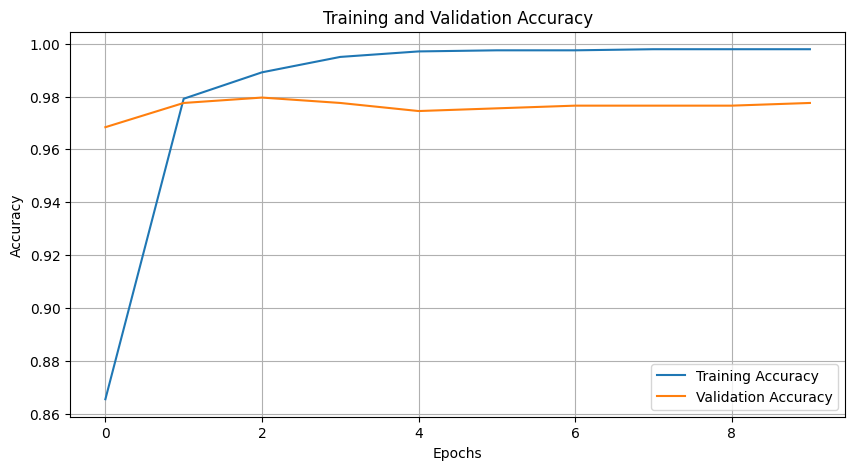

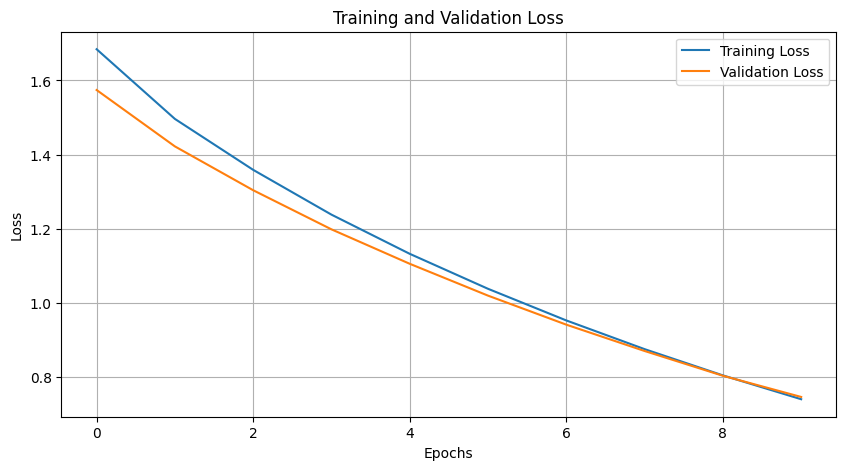

In [13]:
#Plot the accuracy curve
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Save the accuracy plot
plt.savefig('./models/accuracy_curve_mobilenet.png')

# Show the plot
plt.show()

# Plot the loss curve
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the loss plot
plt.savefig('./models/loss_curve-mobilenet.png')

# Show the plot
plt.show()

In [15]:
with open('./history_mobilenet.p' , 'wb') as handle:
    pickle.dump(history.history , handle)

model.save('./models/mobilenetLarge.keras')

In [16]:
model = load_model('./models/mobilenetLarge.keras')

C:\Users\DC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [26]:
decode_dict = {0 : 'cat' , 1 : 'cow' , 2 : 'dog' , 3 : 'hen' , 4 : 'snake' , 5 : 'squirrel'}

In [35]:
# Load the image
img_path = './images (3).jpeg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the input shape of the model (batch_size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (same as during model training)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# For ResNet50, you can decode the predictions (if using pretrained ImageNet classes)
# decoded_predictions = decode_predictions(predictions, top=3)[0]
# print("Predicted:", decoded_predictions)

# If you have custom classes, you'll need to decode the predictions manually
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted class: [4]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

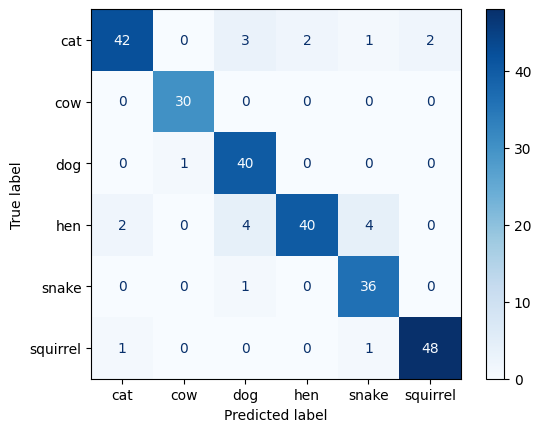

              precision    recall  f1-score   support

         cat       0.93      0.84      0.88        50
         cow       0.97      1.00      0.98        30
         dog       0.83      0.98      0.90        41
         hen       0.95      0.80      0.87        50
       snake       0.86      0.97      0.91        37
    squirrel       0.96      0.96      0.96        50

    accuracy                           0.91       258
   macro avg       0.92      0.92      0.92       258
weighted avg       0.92      0.91      0.91       258



<Figure size 640x480 with 0 Axes>

In [49]:
# Define image directory and labels
image_dir = './data/new_test'  # Update this to your dataset folder path
classes = ['cat', 'cow', 'dog', 'hen', 'snake', 'squirrel']
image_size = (224, 224)  # Adjust according to the model input size


# Initialize lists to store true and predicted labels
y_true = []
y_pred = []
count = 0

# Loop through each class folder
for label in classes:
    class_dir = os.path.join(image_dir, label)
    for image_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, image_name)
        
        # Load and preprocess the image
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize if your model expects this
        
        # Predict the class
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        
        # Append true and predicted labels
        y_true.append(count)
        y_pred.append(predicted_class)

    count = count + 1

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Save the confusion matrix plot
plt.savefig('confusion_matrix.png')

In [52]:
# Save the confusion matrix plot
plt.savefig('./models/confusion_matrix_mobilenet.png')

<Figure size 640x480 with 0 Axes>